In [1]:
import sys
sys.path.insert(0, '../../../network')
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule, set_connectivity, corticostriatal
from sequences import GaussianSequence
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
logging.basicConfig(level=logging.INFO)

### Initialization

In [2]:
params = np.load("./ctx_d1_d2_params.npz", allow_pickle=True) 
N, sequences, patterns, cp, cw, A = params['N'], params['sequences'], params['patterns'], params['cp'], params['cw'], params['A']

In [3]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi

plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8)

# populations
ctx = Population(N=N[0], tau=1e-2, phi=phi, name='ctx')
d1 = Population(N=N[1], tau=1e-2, phi=phi, name='d1')
d2 = Population(N=N[2], tau=1e-2, phi=phi, name='d2')

J = set_connectivity([ctx, d1, d2], cp, cw, A, patterns, plasticity)
network = RateNetwork([ctx, d1, d2], J, formulation=5, disable_pbar=False)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Building connections from ctx to d1
INFO:connectivity:Building connections from ctx to d2
INFO:connectivity:Building connections from d1 to ctx
INFO:connectivity:Building connections from d1 to d1
INFO:connectivity:Building connections from d1 to d2
INFO:connectivity:Building connections from d2 to ctx
INFO:connectivity:Building connections from d2 to d1
INFO:connectivity:Building connections from d2 to d2


### Simulation

In [4]:
# # Specific input
init_inputs = [patterns[0][0][3],
               patterns[1][0][3],
               patterns[2][0][3]]
# Zero input
# init_inputs = [np.zeros(ctx.size),
#                np.zeros(d1.size)]

T=5#ms
mouse = ReachingTask()
network.simulate_learning(mouse, T, init_inputs, patterns, plasticity, (40, 1400, 0.05, 0.6), noise=[0.13,0.13,0.13], 
                          b = [0.05, 0.013, 0.02, 0.05], env=5, learning=False, r_ext=[lambda t:0, lambda t: 1, lambda t: 1], print_output=False, disable_pbar=False)

INFO:network:Integrating network dynamics
100%|██████████| 4999/4999 [00:38<00:00, 139.63it/s]

### Results

In [5]:
overlaps_ctx = sequences[0][0].overlaps(network.pops[0])
overlaps_d1 = sequences[1][0].overlaps(network.pops[1])
overlaps_d2 = sequences[2][0].overlaps(network.pops[2])
# filename = 'simulation-test'
# np.savez('/work/jp464/striatum-sequence/' + 'simulation-pre-learning' + '.npz', 
#          overlaps_ctx=overlaps_ctx, overlaps_d1=overlaps_d1, 
#          state_ctx=network.pops[0].state, state_d1=network.pops[1].state)

INFO:sequences:Computing overlaps

100%|██████████| 4/4 [00:00<00:00, 186.46it/s]
INFO:sequences:Computing overlaps

100%|██████████| 4/4 [00:00<00:00, 341.76it/s]
INFO:sequences:Computing overlaps

100%|██████████| 4/4 [00:00<00:00, 318.90it/s]


100%|██████████| 4999/4999 [00:39<00:00, 128.14it/s]


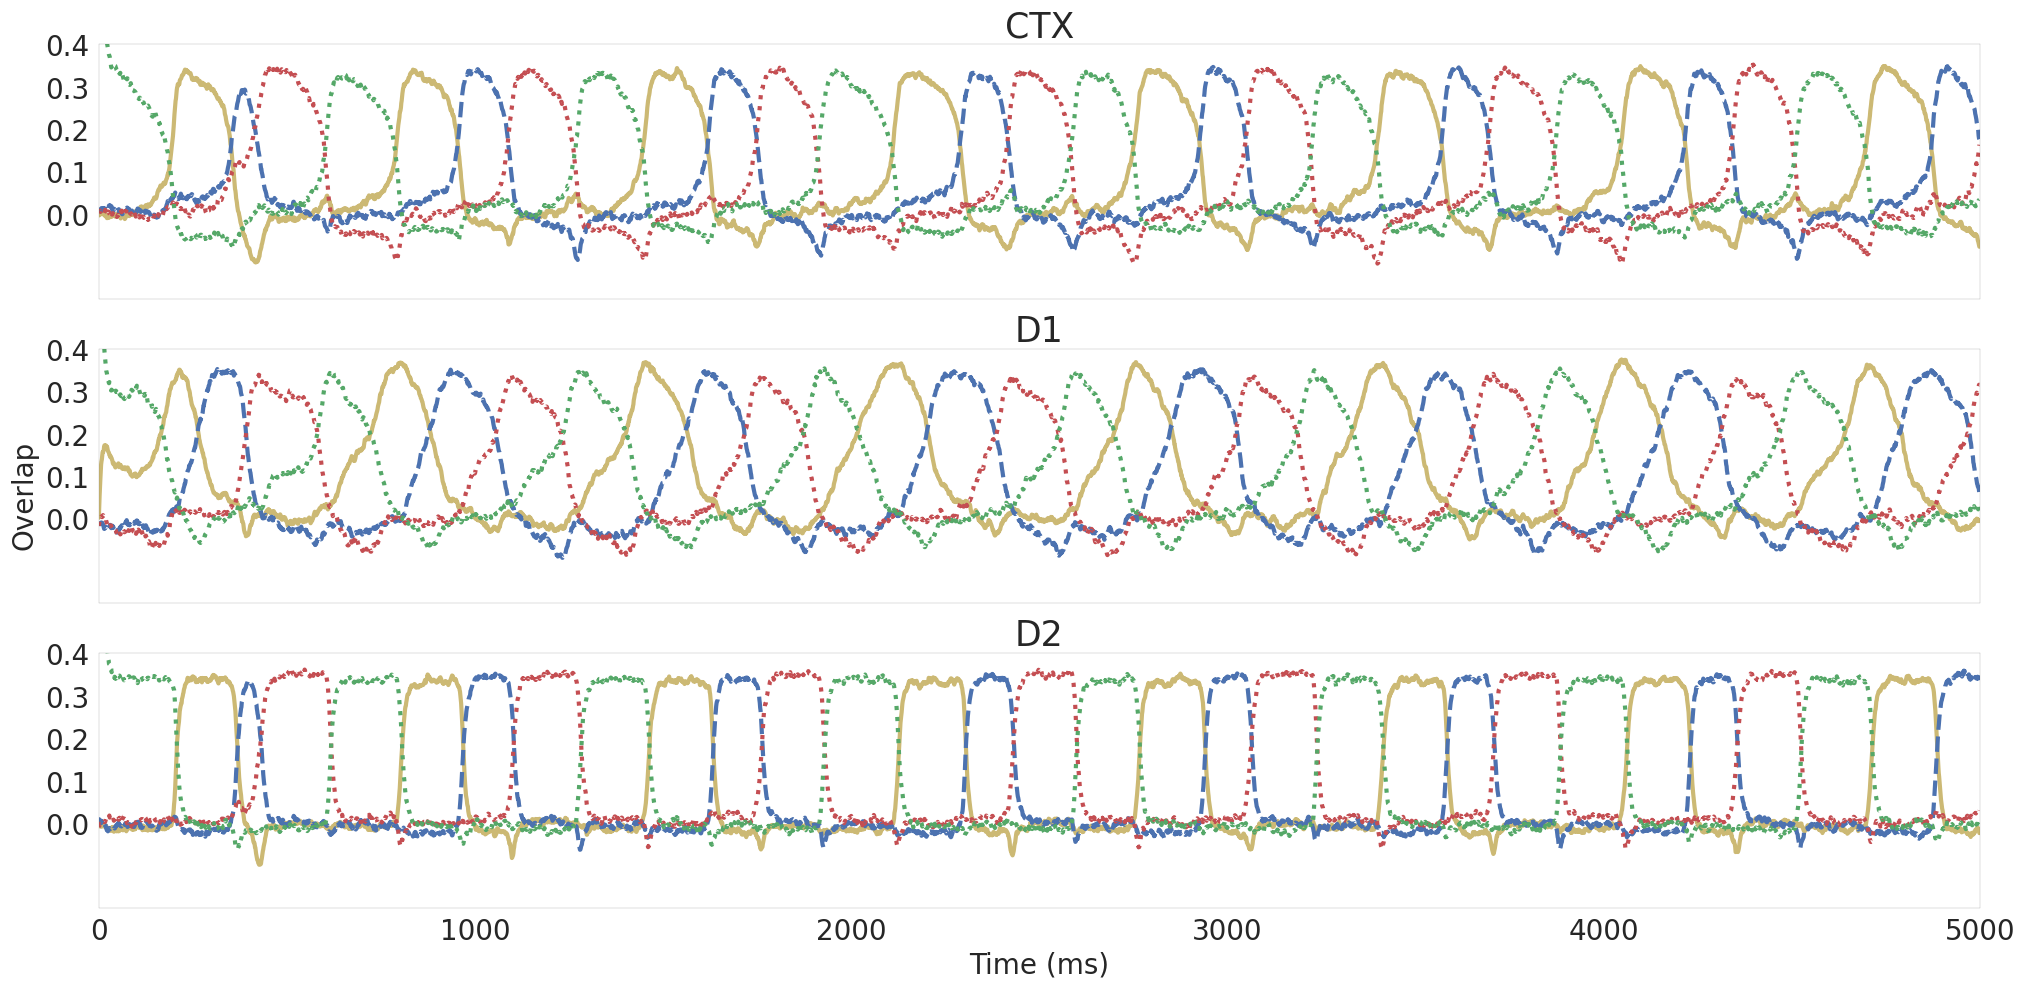

In [6]:
sns.set_style('white') 
colors = sns.color_palette('deep')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams['axes.linewidth'] = 0.1

fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, tight_layout=True, figsize=(20,10))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=3, color=colors[8], label='Aim')
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=3, color=colors[0], label='Reach')
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=3, color=colors[3], label='Lick')
axes[0].plot(overlaps_ctx[3], linestyle='dotted', linewidth=3, color=colors[2], label='Scavenge')
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
axes[1].plot(overlaps_d1[0], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(overlaps_d1[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(overlaps_d1[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].plot(overlaps_d1[3], linestyle='dotted', linewidth=3, color=colors[2])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("D1", fontsize=25)
axes[2].plot(overlaps_d2[0], linestyle='solid', linewidth=3, color=colors[8])
axes[2].plot(overlaps_d2[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[2].plot(overlaps_d2[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[2].plot(overlaps_d2[3], linestyle='dotted', linewidth=3, color=colors[2])
axes[2].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[2].set_title("D2", fontsize=25)
axes[2].set_xlabel('Time (ms)', fontsize=20)

fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0,5000))
plt.setp(axes, ylim=(-.2, .4))
# plt.figlegend(fontsize=20, loc='upper right')
# plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.savefig('/work/jp464/striatum-sequence/output/d1-d2-pre-inhibition.jpg', bbox_inches = "tight", format='jpg')

plt.show()
